### Web Scraper: Extracting Fact-Checked Data from Politifact with Python and Beautiful Soup

*Iván Arcos*

*El código realiza un web scraping en la página web de Politifact para obtener afirmaciones relacionadas con el cambio climático y etiquetarlas según su veracidad. Para esto, se recorren las primeras 12 páginas de la sección de fact-checking de la página y se extraen la afirmación, la evidencia y la etiqueta de veracidad de cada afirmación.*

*En cada página, se hace una solicitud web a la URL de la página y se utiliza BeautifulSoup para analizar el contenido de la página. Se busca la fecha de la afirmación y se extrae la afirmación en sí. Luego se accede a la página de la afirmación para extraer todas las evidencias.*

*Se divide el texto de las evidencias en oraciones y se busca la última oración que contenga una etiqueta de veracidad. Se asigna una etiqueta de veracidad a la afirmación según el contenido de esa última oración.*

*Si no se encuentra una etiqueta de veracidad en la última oración, se busca una imagen con una etiqueta de veracidad y se asigna la etiqueta correspondiente. Si no se encuentra una etiqueta de veracidad en ninguna parte, se asigna None.*

*Finalmente, se crea un dataframe con las afirmaciones, las evidencias, las etiquetas de veracidad y las fechas y se exporta como un archivo CSV.*

In [ ]:
import requests # librería para hacer solicitudes web
from bs4 import BeautifulSoup # librería para hacer web scraping
import pandas as pd # librería para trabajar con dataframes

claims = [] # lista vacía donde se guardarán las afirmaciones
evidences = [] # lista vacía donde se guardarán las evidencias
fechas = [] # lista vacía donde se guardarán las fechas
labels = [] # lista vacía donde se guardarán las etiquetas

for page_num in range(1, 13): # bucle para recorrer las 12 primeras páginas de Politifact
    print(f"Analizando página {page_num}") # se imprime la página que se está analizando
    url = f"https://www.politifact.com/factchecks/list/?page={page_num}&category=climate-change" # url de la página a analizar
    page = requests.get(url) # se hace la solicitud web a la url
    soup = BeautifulSoup(page.content, "html.parser") # se utiliza BeautifulSoup para analizar el contenido de la página
    fechasp = [f.text.strip().split('•')[1].strip() for f in soup.find_all('footer', class_="m-statement__footer")] # se busca la fecha de la afirmación
    quotes = soup.find_all("div", class_="m-statement__quote") # se busca la afirmación

    cont = 0 # contador para recorrer la lista de fechas
    for quote in quotes: # bucle para recorrer cada afirmación
        claim_url = quote.find("a")["href"] # se obtiene el enlace a la página de la afirmación
        try:
            claim_page = requests.get(f"https://www.politifact.com{claim_url}") # se hace la solicitud web a la página de la afirmación
            print(f"\tAnalizando: https://www.politifact.com{claim_url}") # se imprime la página que se está analizando
            claim_soup = BeautifulSoup(claim_page.content, "html.parser") # se utiliza BeautifulSoup para analizar el contenido de la página de la afirmación

            # se extrae la afirmación
            claim = quote.find("a").text.strip() 
            print(claim)

            # se extraen todas las evidencias
            evidence = ""
            paragraphs = claim_soup.find("article", class_="m-textblock").find_all("p")
            for paragraph in paragraphs:
                if "RELATED: " not in paragraph.text:
                    evidence += paragraph.text + " "

            # se divide el texto de las evidencias en oraciones
            ev = evidence.split('.')
            
            # se busca la última oración que contenga una etiqueta de veracidad
            for i in range(-10,0,1):
                if "Mostly True" in ev[i] or 'Half True' in ev[i] or 'Mostly False' in ev[i] or 'False Pants on Fire' in ev[i] or 'Pants on Fire' in ev[i] or 'True' in ev[i] or 'False' in ev[i] :
                    cut = i
                    break
            ult = ev[cut]
            if "Mostly True" in ult:
                labels.append('Mostly True')
                evidences.append('.'.join(evidence.split('.')[:cut]))
            elif 'Half True' in ult:
                labels.append('Half True')
                evidences.append('.'.join(evidence.split('.')[:cut]))
            elif 'Mostly False' in ult:
                labels.append('Mostly False')
                evidences.append('.'.join(evidence.split('.')[:cut]))
            elif 'False Pants on Fire' in ult or 'Pants on Fire' in ult:
                labels.append('False Pants on Fire')
                evidences.append('.'.join(evidence.split('.')[:cut]))
            elif 'True' in ult:
                labels.append('True')
                evidences.append('.'.join(evidence.split('.')[:cut]))
            elif 'False' in ult:
                labels.append('False')
                evidences.append('.'.join(evidence.split('.')[:cut]))
            """
            Si no se encuentra una etiqueta de veracidad en la última oración, se busca una imagen 
            con una etiqueta de veracidad y se asigna la etiqueta correspondiente. Si no se encuentra una 
            etiqueta de veracidad en ninguna parte, se asigna None.
            """
            else:
                l = claim_soup.find("img", class_ = 'c-image__original ', width=219)['alt']
                evidences.append('.'.join(evidence.split('.')))
                print(evidence, l, f"https://www.politifact.com{claim_url}")
                if l == "true":
                    labels.append('True')
                elif l == "mostly-true":
                    labels.append('Mostly True')
                elif l == "half-true":
                    labels.append('Half True')  
                elif l == "barely-true":
                    labels.append('Mostly False')
                elif l == "false":
                    labels.append('False')
                elif l == "pants-fire":
                    labels.append('False Pants on Fire')
                else:
                    labels.append(None)
            fechas.append(fechasp[cont])
            claims.append(claim)
        except:
            print(f"Fallo en https://www.politifact.com{claim_url}")
        cont += 1
# Finalmente, se crea un dataframe con las afirmaciones, las evidencias, las etiquetas de veracidad y las fechas y se exporta como un archivo CSV.
df = pd.DataFrame({"claim": claims, "evidences": evidences,
                   "label": labels,"fecha": fechas})
# export as CSV
df.to_csv("climate_change.csv", index=False)
df

### Extrayendo todas las temáticas de Politifact

In [20]:
import os
import pandas as pd
all_topics_data = pd.DataFrame(columns = ['claim','evidences','label','fecha','topic'])
for topic in os.listdir('topics'):
    df = pd.read_csv(f'topics\{topic}')
    df['topic'] = [topic[:-4]] * len(df)
    all_topics_data = pd.concat([all_topics_data, df])

In [52]:
all_topics_data = all_topics_data.reset_index(drop = True).drop_duplicates()
all_topics_data['año'] = [f.split(',')[-1].strip() for f in all_topics_data['fecha']]
all_topics_data

,claim,evidences,label,fecha,topic,año
0,“Humans are not causing climate change.” Magne...,Is the Earth’s magnetic field affecting our cl...,False,"February 15, 2023",climate_change,2023
1,"“Right now, driving 100 miles in an electric v...",Last year’s soaring gasoline prices drove many...,Half True,"February 14, 2023",climate_change,2023
2,Wind farm construction is a possible cause of ...,Is a surge in whale deaths on the Atlantic Coa...,Mostly False,"February 8, 2023",climate_change,2023
3,Global warming is a “fraud.”,Multiple social media posts continue to downpl...,False,"January 31, 2023",climate_change,2023
4,“NASA stopped exploring the ocean.”,"A video shared on Instagram claimed that NASA,...",False Pants on Fire,"January 30, 2023",climate_change,2023
...,...,...,...,...,...,...
11634,"""Five percent of Americans pay over half the i...","Fred Thompson, in arguing that the tax cuts of...",True,"December 13, 2007",taxes,2007
11635,"""I believe in tax cuts. I believe in being a s...",\nUpdated: Rudy Giuliani is deft at cherry-pic...,Mostly True,"November 21, 2007",taxes,2007
11636,"""As governor of Arkansas, I cut taxes and fees...",Ever since setting up his committee to explore...,Half True,"November 14, 2007",taxes,2007
11637,"""Our tax code is so complicated it extracts $1...",Sen. John McCain wants to overhaul our complex...,Half True,"November 5, 2007",taxes,2007


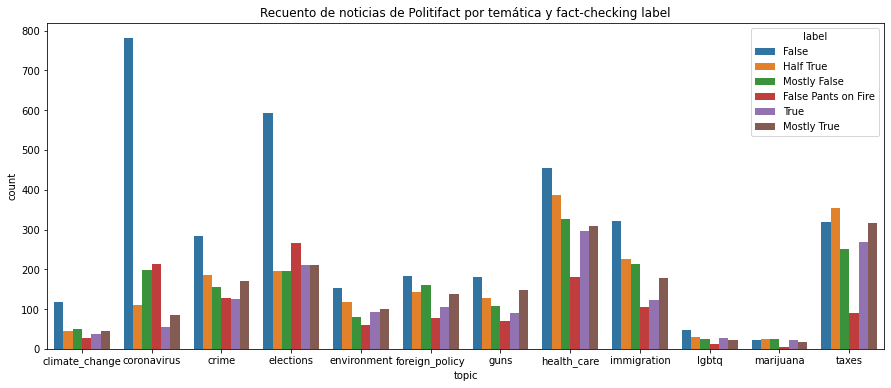

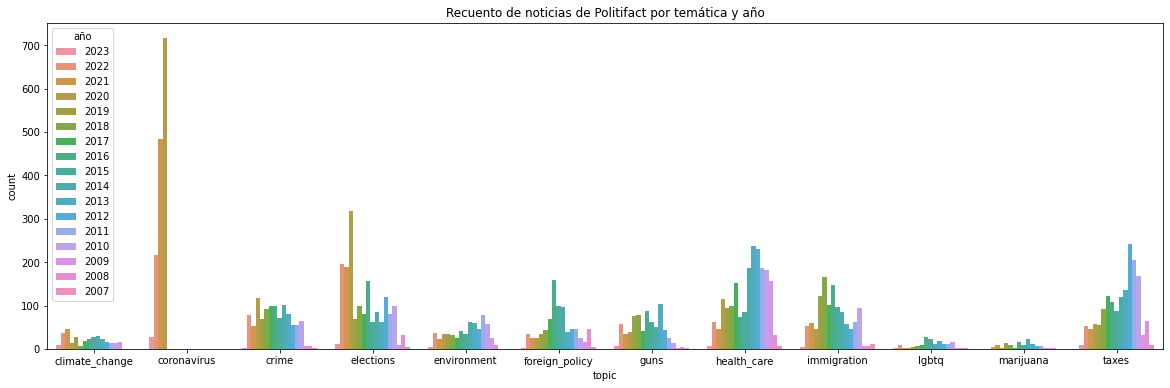

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt


# crea el gráfico de barras usando seaborn
plt.figure(figsize = (15,6))
sns.countplot(x='topic', hue='label', data=all_topics_data)
plt.title("Recuento de noticias de Politifact por temática y fact-checking label")
plt.show()

# crea el gráfico de barras usando seaborn
plt.figure(figsize = (20,6))
sns.countplot(x='topic', hue='año', data=all_topics_data)
plt.title("Recuento de noticias de Politifact por temática y año")
plt.show()